<img src="monai.png" style="width: 700px;"/>

Welcome to the MONAI bootcamp! This notebook will introduce you to an end-to-end workin in MONAI using both a standard PyTorch loop and using Ignite, followed by a hands-on implementing your own segmentation using everything you've learned so far.

### Using Google Colab

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.

**Required Packages for Colab Execution**

Execute the following cell to install MONAI the first time a colab notebook is run:


In [1]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

**Enabling GPU Support**

To use GPU resources through Colab, change the runtime to GPU:

1. From the **"Runtime"** menu select **"Change Runtime Type"**
2. Choose **"GPU"** from the drop-down menu
3. Click **"SAVE"**

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running

**!nvidia-smi**

in a cell will verify this has worked and show you what kind of hardware you have access to.    

In [2]:
!nvidia-smi

Thu Jan 27 12:58:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   33C    P8    15W / 215W |     10MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# End-to-end Training with Pytorch and Ignite
---

We've covered a lot of material and now it's time to apply the things that we've learned in an end-to-end example.  First, we're going to use the basic PyTorch paradigm for training our model.  We'll then look at how to train using the Ignite workflows to make things even easier!


## End-to-End Training Workflow

To help guide you through training your first model using MONAI, this guide will will cover five key phases:

1. **Setting up our Dataset and exploring the data**
2. **Preparing datasets and transforms**
3. **Define your network and create our PyTorch training loop**
4. **Evaluate your model and understand the results**
5. **Start using Ignite and more about determinism**


Let's get started by importing our dependencies.

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType
)
from monai.utils import set_determinism

## **1. Setting up our Dataset and exploring the data**

#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called MONAI_DATA_DIRECTORY.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp5xjqykzb


#### Download the MedNIST dataset
The `MedNIST` dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). If you use the MedNIST dataset, please acknowledge the source.

We're going to download this dataset below and extract it into our temporary MONAI Data Directory.

In [5]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:06, 9.22MB/s]                                        


Downloaded: /tmp/tmp5xjqykzb/MedNIST.tar.gz
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Writing into directory: /tmp/tmp5xjqykzb.


#### Set deterministic training for reproducibility
[set_determinism](https://docs.monai.io/en/latest/utils.html?highlight=set_determinism#monai.utils.misc.set_determinism) will set the random seeds in both Numpy and PyTorch to ensure reproducibility. We'll see later that we need to go a little bit further to ensure reproducibility in a jupyter notebook

In [6]:
set_determinism(seed=0)

#### Read the image filenames from the dataset folders

When using a dataset, you want to understand the basics of the images, labels, and more.  We'll start off by showing some of those basic statistics for MedNIST.

We'll see that 6 different folders are representing 6 different categories: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT.  We'll be using each of these categories as our label names. 

In [7]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
    
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


#### Randomly pick images from the dataset to visualize and check

We want to understand what the images we're using look like, so we'll start by visualizing a few random images.

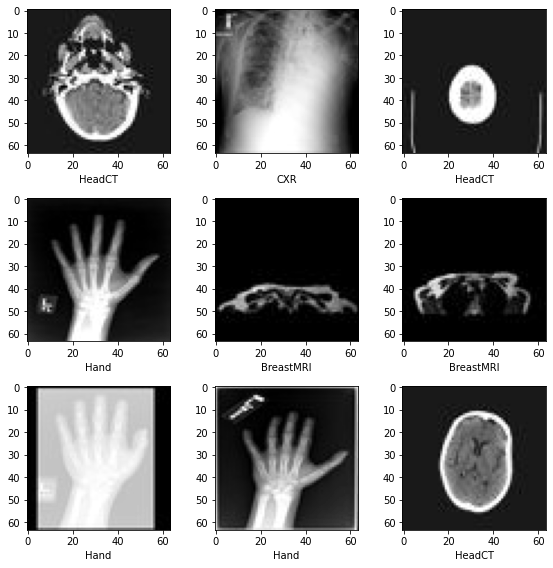

In [9]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## **2. Preparing datasets and transforms**

#### Prepare training, validation, and test data lists

We want to split the data into 3 different sets, one for training, one for validation, and one for testing.  We'll use a ratio of 80/10/10 for those sets.

In [10]:
train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)), 
                                                            image_class,(8, 1, 1), shuffle=True)

train_x = [image_files_list[i] for i in train_inds]
train_y = [image_class[i] for i in train_inds]
val_x = [image_files_list[i] for i in val_inds]
val_y = [image_class[i] for i in val_inds]
test_x = [image_files_list[i] for i in test_inds]
test_y = [image_class[i] for i in test_inds]

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47163, Validation count: 5895, Test count: 5895


#### Define MONAI transforms, Dataset and Dataloader to pre-process data

We'll define our transform using `Compose`.  In this Array of Transforms, we'll load the image, add a channel, scale its intensity, utilize a few random functions and finally create a tensor.

In [11]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

act = Compose([EnsureType(), Activations(softmax=True)])
to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

#### Initialise the datasets and loaders for training, validation and test sets
 * Define a simple dataset, that we'll call `MedNISTDataset`, that groups:
   * Images
   * Labels
   * The transforms that are to be run on the images and labels
 * Create three instances of this dataset:
   * One for training
   * One for validation
   * One for testing
   
We'll use a batch size of 512 and employ 10 workers to load the data.

In [12]:
batch_size = 512
num_workers = 10

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


## **3. Define your network and create our PyTorch training loop**

#### Define network and optimizer

1. Set `learning_rate` for how much the model is updated per step
1. The fetch a pytorch `device` for the GPU
1. Instantiate a [densenet121](https://docs.monai.io/en/latest/networks.html?highlight=densenet#monai.networks.nets.densenet121) model instance and 'send' it to the GPU using `device`
  * This is a standard MONAI implementation; it is capable of 2D and 3D operation but here we are using it in 2D mode
1. We'll make use of the Adam optimizer

In [13]:
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

#### Network training
We are hand-rolling a basic pytorch training loop here:
 * standard pytorch training loop
   * step through each training epoch, running through the training set in batches
   * after each epoch, run a validation pass, evaluating the network
   * if it shows improved performance, save out the model weights
 * later we will revisit training loops in a more Ignite / MONAI fashion

In [14]:
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()
        
        # run the network forwards
        outputs = net(inputs)
        
        # run the loss function on the outputs
        loss = loss_function(outputs, labels)
        
        # compute the gradients
        loss.backward()
        
        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out
    
    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        preds = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y)]        
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]
        
        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)
        
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        
        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")
            
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/93, training_loss: 1.7830
2/93, training_loss: 1.7657
3/93, training_loss: 1.7354
4/93, training_loss: 1.7156
5/93, training_loss: 1.6784
6/93, training_loss: 1.6679
7/93, training_loss: 1.6549
8/93, training_loss: 1.6111
9/93, training_loss: 1.5915
10/93, training_loss: 1.5724
11/93, training_loss: 1.5674
12/93, training_loss: 1.5323
13/93, training_loss: 1.5261
14/93, training_loss: 1.5081
15/93, training_loss: 1.4679
16/93, training_loss: 1.4502
17/93, training_loss: 1.4552
18/93, training_loss: 1.4156
19/93, training_loss: 1.3716
20/93, training_loss: 1.3890
21/93, training_loss: 1.3656
22/93, training_loss: 1.3657
23/93, training_loss: 1.3542
24/93, training_loss: 1.3247
25/93, training_loss: 1.3191
26/93, training_loss: 1.2616
27/93, training_loss: 1.2761
28/93, training_loss: 1.2343
29/93, training_loss: 1.2241
30/93, training_loss: 1.2086
31/93, training_loss: 1.1855
32/93, training_loss: 1.1936
33/93, training_loss: 1.1822
34/93, training_loss: 1.1757
35

86/93, training_loss: 0.1505
87/93, training_loss: 0.1370
88/93, training_loss: 0.1185
89/93, training_loss: 0.1202
90/93, training_loss: 0.1322
91/93, training_loss: 0.1456
92/93, training_loss: 0.1201
93/93, training_loss: 0.1076
epoch 3 average loss: 0.1675
saved new best metric network
current epoch: 3 current AUC: 0.9994 / current accuracy: 0.9817 best AUC: 0.9994 / at epoch: 3
----------
epoch 4/4
1/93, training_loss: 0.1177
2/93, training_loss: 0.1272
3/93, training_loss: 0.1296
4/93, training_loss: 0.1156
5/93, training_loss: 0.1164
6/93, training_loss: 0.1237
7/93, training_loss: 0.1237
8/93, training_loss: 0.1105
9/93, training_loss: 0.1226
10/93, training_loss: 0.1400
11/93, training_loss: 0.1178
12/93, training_loss: 0.1140
13/93, training_loss: 0.1117
14/93, training_loss: 0.1330
15/93, training_loss: 0.1291
16/93, training_loss: 0.1195
17/93, training_loss: 0.1087
18/93, training_loss: 0.1283
19/93, training_loss: 0.1149
20/93, training_loss: 0.1156
21/93, training_loss: 

#### Plot the loss and metric

Once we're done training we want to visualize our Loss and Accuracy.

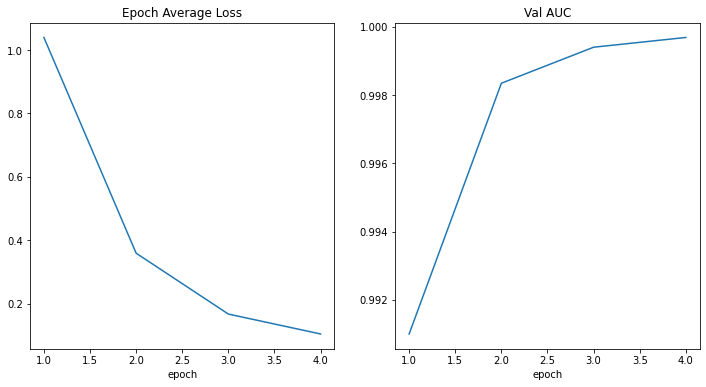

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## **4. Evaluate your model and understand the results**

#### Evaluate the model on the test dataset

After training and validation, we now have the best model as determined by the validation dataset.  But now we need to evaluate the model on the test dataset to check whether the final model is robust and not over-fitting.  We'll use these predictions to generate a classification report.

In [16]:
net.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

#### Some light analytics - classification report

We'll utilize scikit-learn's classification report to get the precision, recall, and f1-score for each category.

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9789    0.9720    0.9754      1000
   BreastMRI     0.9933    0.9944    0.9939       895
         CXR     0.9920    0.9930    0.9925      1000
     ChestCT     0.9960    1.0000    0.9980      1000
        Hand     0.9939    0.9820    0.9879      1000
      HeadCT     0.9724    0.9850    0.9786      1000

    accuracy                         0.9876      5895
   macro avg     0.9877    0.9877    0.9877      5895
weighted avg     0.9876    0.9876    0.9876      5895



#### Some light analytics - confusion matrix

Let's also create a confusion matrix to get a better understanding of the failure cases

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


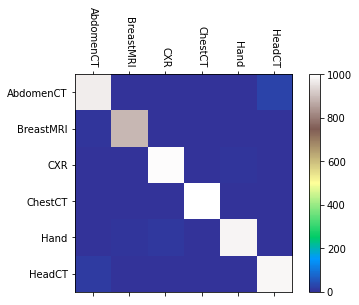

In [18]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="terrain", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

plt.show()

## **5. Start using Ignite and more about determinism**

#### Let's make some changes
Everything that we have done so far uses MONAI with pytorch in a very vanilla fashion. The initial training / validation loop is written to show you the nuts and bolts of pytorch. Now let's explore starting the move towards [Ignite](https://pytorch.org/ignite/) and features of MONAI designed to work with it.

<img src="workflows.png" style="width: 700px;"/>

In [19]:
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Accuracy
from monai.handlers import ROCAUC

step = 1
iter_losses=[]
batch_sizes=[]
epoch_loss_values = []
metric_values = []

# Training

# this trainer takes care of the training loop for us
trainer = create_supervised_trainer(net, optimizer, loss_function, device, False)

# calculate the number of steps per epoch up front
steps_per_epoch = len(train_ds) // train_loader.batch_size
if len(train_ds) % train_loader.batch_size != 0:
    steps_per_epoch += 1


# create a handler for recording the loss after each input. Improve upon our earlier example
# by also recording the batch size, so we can perform a weighted average for the overall average
# loss
@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine):
    global step
    loss = engine.state.output
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    iter_losses.append(loss)
    batch_sizes.append(batch_len)
    print(f'epoch {epoch}/{epoch_len}, step {step}/{steps_per_epoch}, training_loss = {loss:.4f}')    
    step += 1
    
# Validation

def roc_auc_trans(x):
    return [act(i) for i in decollate_batch(x[0])], [to_onehot(i) for i in decollate_batch(x[1])]

val_metrics = {
    'accuracy': Accuracy(), 
    'rocauc': ROCAUC(output_transform=roc_auc_trans)
}
evaluator = create_supervised_evaluator(
    net,
    val_metrics,
    device,
    True
)


# validation is run every n training epochs in response to the trainer completing
# an epoch. Here we use the decorator syntax to add a function that runs it to the
# EPOCH_COMPLETED event
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    global step
    evaluator.run(val_loader)

    # the overall average loss must be weighted by batch size
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)

    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]
    
    # fetch and report the validation metrics
    acc = evaluator.state.metrics['accuracy']
    roc = evaluator.state.metrics['rocauc']
    metric_values.append(roc)
    print(f"evaluation for epoch {engine.state.epoch}, accuracy = {acc:.4f}, rocauc = {roc:.4f}")

    # reset step for the next epoch
    step = 1
    
# create a checkpoint handler to save the network weights based on the area under the ROC curve
# as before
def _score(_):
    return metric_values[-1]

# create a model checkpointer to save the network
checkpoint_handler = ModelCheckpoint(root_dir, filename_prefix='best_metric_model', score_name='',
                                     n_saved=1, require_empty=False, score_function=_score)

# handlers are attached to events in trainers and evaluators
trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED,
                          handler=checkpoint_handler, to_save={'net': net})

# train (and evaluate) the network, Ignite-style!
train_epochs = 4
state = trainer.run(train_loader, train_epochs)

best_rocauc = max(metric_values)
print(f"train completed, best_metric: {best_rocauc:.4f} at epoch: {metric_values.index(best_rocauc)}")

This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


epoch 1/4, step 1/93, training_loss = 0.0882
epoch 1/4, step 2/93, training_loss = 0.0985
epoch 1/4, step 3/93, training_loss = 0.0840
epoch 1/4, step 4/93, training_loss = 0.0994
epoch 1/4, step 5/93, training_loss = 0.0775
epoch 1/4, step 6/93, training_loss = 0.0736
epoch 1/4, step 7/93, training_loss = 0.0714
epoch 1/4, step 8/93, training_loss = 0.0813
epoch 1/4, step 9/93, training_loss = 0.0925
epoch 1/4, step 10/93, training_loss = 0.0817
epoch 1/4, step 11/93, training_loss = 0.0845
epoch 1/4, step 12/93, training_loss = 0.0765
epoch 1/4, step 13/93, training_loss = 0.0807
epoch 1/4, step 14/93, training_loss = 0.0759
epoch 1/4, step 15/93, training_loss = 0.0923
epoch 1/4, step 16/93, training_loss = 0.0811
epoch 1/4, step 17/93, training_loss = 0.0583
epoch 1/4, step 18/93, training_loss = 0.0562
epoch 1/4, step 19/93, training_loss = 0.0725
epoch 1/4, step 20/93, training_loss = 0.0847
epoch 1/4, step 21/93, training_loss = 0.0698
epoch 1/4, step 22/93, training_loss = 0.09

epoch 2/4, step 86/93, training_loss = 0.0697
epoch 2/4, step 87/93, training_loss = 0.0854
epoch 2/4, step 88/93, training_loss = 0.0459
epoch 2/4, step 89/93, training_loss = 0.0475
epoch 2/4, step 90/93, training_loss = 0.0633
epoch 2/4, step 91/93, training_loss = 0.0442
epoch 2/4, step 92/93, training_loss = 0.0497
epoch 2/4, step 93/93, training_loss = 0.0565
evaluation for epoch 2, accuracy = 0.9929, rocauc = 0.9999
epoch 3/4, step 1/93, training_loss = 0.0465
epoch 3/4, step 2/93, training_loss = 0.0553
epoch 3/4, step 3/93, training_loss = 0.0469
epoch 3/4, step 4/93, training_loss = 0.0462
epoch 3/4, step 5/93, training_loss = 0.0464
epoch 3/4, step 6/93, training_loss = 0.0498
epoch 3/4, step 7/93, training_loss = 0.0516
epoch 3/4, step 8/93, training_loss = 0.0490
epoch 3/4, step 9/93, training_loss = 0.0391
epoch 3/4, step 10/93, training_loss = 0.0556
epoch 3/4, step 11/93, training_loss = 0.0487
epoch 3/4, step 12/93, training_loss = 0.0352
epoch 3/4, step 13/93, trainin

epoch 4/4, step 76/93, training_loss = 0.0210
epoch 4/4, step 77/93, training_loss = 0.0452
epoch 4/4, step 78/93, training_loss = 0.0285
epoch 4/4, step 79/93, training_loss = 0.0284
epoch 4/4, step 80/93, training_loss = 0.0495
epoch 4/4, step 81/93, training_loss = 0.0445
epoch 4/4, step 82/93, training_loss = 0.0314
epoch 4/4, step 83/93, training_loss = 0.0213
epoch 4/4, step 84/93, training_loss = 0.0342
epoch 4/4, step 85/93, training_loss = 0.0474
epoch 4/4, step 86/93, training_loss = 0.0560
epoch 4/4, step 87/93, training_loss = 0.0270
epoch 4/4, step 88/93, training_loss = 0.0319
epoch 4/4, step 89/93, training_loss = 0.0400
epoch 4/4, step 90/93, training_loss = 0.0299
epoch 4/4, step 91/93, training_loss = 0.0398
epoch 4/4, step 92/93, training_loss = 0.0201
epoch 4/4, step 93/93, training_loss = 0.0402
evaluation for epoch 4, accuracy = 0.9954, rocauc = 0.9999
train completed, best_metric: 0.9999 at epoch: 3


This demonstrates using Ignite directly with MONAI. The Engine class used here is also extended by MONAI to provide further facilities related to determinism, providing a default training/evaluating iteration implementation, and dealing with the post-processing of data. These types are not necessary so those new to Ignite or already have their own Ignite-based code can integrate MONAI without having to pick up our types.

Using our MONAI classes we can define a simplified version (with a few features omitted):

In [20]:
from ignite.engine import Events
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Accuracy
from monai.handlers import ROCAUC, ValidationHandler
from monai.engines import SupervisedTrainer, SupervisedEvaluator

train_epochs = 4
iter_losses = []
batch_sizes = []
epoch_loss_values = []
metric_values = []

steps_per_epoch = len(train_ds) // train_loader.batch_size
if len(train_ds) % train_loader.batch_size != 0:
    steps_per_epoch += 1


def roc_auc_trans(x):
    if isinstance(x, list):
        pred = torch.cat([i[0][None, :] for i in x])
        label = torch.cat([i[1][None, :] for i in x])
        return pred, label

    return act(x["pred"]), to_onehot(x["label"])


def prepare_batch(batchdata, device, non_blocking):
    img, classes = batchdata
    return img.to(device), classes.to(device)


evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    postprocessing=roc_auc_trans,
    key_val_metric={"rocauc": ROCAUC(output_transform=roc_auc_trans)},
    prepare_batch=prepare_batch,
)

trainer = SupervisedTrainer(
    device=device,
    max_epochs=train_epochs,
    train_data_loader=train_loader,
    network=net,
    optimizer=optimizer,
    loss_function=loss_function,
    train_handlers=[ValidationHandler(1, evaluator)],
    prepare_batch=prepare_batch,
)


@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine):
    loss = np.average([o["loss"] for o in engine.state.output])
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    step = engine.state.iteration + 1
    iter_losses.append(loss)
    batch_sizes.append(batch_len)

    print(f"epoch {epoch}/{epoch_len}, step {step}/{steps_per_epoch}, training_loss = {loss:.4f}")


@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    # the overall average loss must be weighted by batch size
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)

    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]

    # fetch and report the validation metrics
    roc = evaluator.state.metrics["rocauc"]
    metric_values.append(roc)
    print(f"evaluation for epoch {engine.state.epoch},  rocauc = {roc:.4f}")


trainer.run()

epoch 1/4, step 2/93, training_loss = 0.0339
epoch 1/4, step 3/93, training_loss = 0.0345
epoch 1/4, step 4/93, training_loss = 0.0311
epoch 1/4, step 5/93, training_loss = 0.0304
epoch 1/4, step 6/93, training_loss = 0.0276
epoch 1/4, step 7/93, training_loss = 0.0259
epoch 1/4, step 8/93, training_loss = 0.0380
epoch 1/4, step 9/93, training_loss = 0.0250
epoch 1/4, step 10/93, training_loss = 0.0332
epoch 1/4, step 11/93, training_loss = 0.0202
epoch 1/4, step 12/93, training_loss = 0.0310
epoch 1/4, step 13/93, training_loss = 0.0312
epoch 1/4, step 14/93, training_loss = 0.0290
epoch 1/4, step 15/93, training_loss = 0.0278
epoch 1/4, step 16/93, training_loss = 0.0271
epoch 1/4, step 17/93, training_loss = 0.0308
epoch 1/4, step 18/93, training_loss = 0.0448
epoch 1/4, step 19/93, training_loss = 0.0224
epoch 1/4, step 20/93, training_loss = 0.0275
epoch 1/4, step 21/93, training_loss = 0.0297
epoch 1/4, step 22/93, training_loss = 0.0500
epoch 1/4, step 23/93, training_loss = 0.0

epoch 2/4, step 178/93, training_loss = 0.0321
epoch 2/4, step 179/93, training_loss = 0.0197
epoch 2/4, step 180/93, training_loss = 0.0310
epoch 2/4, step 181/93, training_loss = 0.0297
epoch 2/4, step 182/93, training_loss = 0.0166
epoch 2/4, step 183/93, training_loss = 0.0242
epoch 2/4, step 184/93, training_loss = 0.0137
epoch 2/4, step 185/93, training_loss = 0.0270
epoch 2/4, step 186/93, training_loss = 0.0236
epoch 2/4, step 187/93, training_loss = 0.0699
evaluation for epoch 2,  rocauc = 1.0000
epoch 3/4, step 188/93, training_loss = 0.0159
epoch 3/4, step 189/93, training_loss = 0.0197
epoch 3/4, step 190/93, training_loss = 0.0262
epoch 3/4, step 191/93, training_loss = 0.0199
epoch 3/4, step 192/93, training_loss = 0.0205
epoch 3/4, step 193/93, training_loss = 0.0291
epoch 3/4, step 194/93, training_loss = 0.0199
epoch 3/4, step 195/93, training_loss = 0.0155
epoch 3/4, step 196/93, training_loss = 0.0265
epoch 3/4, step 197/93, training_loss = 0.0229
epoch 3/4, step 198

epoch 4/4, step 351/93, training_loss = 0.0235
epoch 4/4, step 352/93, training_loss = 0.0173
epoch 4/4, step 353/93, training_loss = 0.0198
epoch 4/4, step 354/93, training_loss = 0.0138
epoch 4/4, step 355/93, training_loss = 0.0233
epoch 4/4, step 356/93, training_loss = 0.0235
epoch 4/4, step 357/93, training_loss = 0.0120
epoch 4/4, step 358/93, training_loss = 0.0147
epoch 4/4, step 359/93, training_loss = 0.0108
epoch 4/4, step 360/93, training_loss = 0.0104
epoch 4/4, step 361/93, training_loss = 0.0133
epoch 4/4, step 362/93, training_loss = 0.0177
epoch 4/4, step 363/93, training_loss = 0.0133
epoch 4/4, step 364/93, training_loss = 0.0134
epoch 4/4, step 365/93, training_loss = 0.0182
epoch 4/4, step 366/93, training_loss = 0.0257
epoch 4/4, step 367/93, training_loss = 0.0092
epoch 4/4, step 368/93, training_loss = 0.0169
epoch 4/4, step 369/93, training_loss = 0.0336
epoch 4/4, step 370/93, training_loss = 0.0111
epoch 4/4, step 371/93, training_loss = 0.0170
epoch 4/4, st

## Issues with determinism

MONAI provides `monai.utils.set_determinism` for replicable training
- Easy to not think about, especially in a jupyter / IPython notebook

How many uses of `numpy.random`'s underlying global instance does this notebook have?
- Dataset partitioning
- Image previewing
- MONAI transforms with randomised behaviour can be given / told to create their own internal `numpy.random.RandomState` instances


#### Setting up transforms, revisited

In [21]:
rseed = 12345678

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True).set_random_state(rseed),
        RandFlip(spatial_axis=0, prob=0.5).set_random_state(rseed),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5).set_random_state(rseed),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

#### Improving dataset partitioning

Current code results in random numbers of images / labels each time it is run in each category. The solution is to use a deterministic shuffle:

In [22]:
parts = partition_dataset_classes(
    data=np.arange(len(image_files_list)), 
    classes=image_class, 
    ratios=(8, 1, 1), 
    shuffle=True, 
    seed=rseed
)

image_sets = [list(), list(), list()]
label_sets = [list(), list(), list()]

for i, part in enumerate(parts):
    image_sets[i] = [image_files_list[idx] for idx in part]
    label_sets[i] = [image_class[idx] for idx in part]

train_x, val_x, test_x = image_sets
train_y, val_y, test_y = label_sets
print(len(train_x), len(val_x), len(test_x))

47163 5895 5895


## **Summary**

In this notebook, we went through an end-to-end workflow to train the MedNIST dataset using a densenet121 network.  Along the way, you did the following:
- Learned about the MedNIST Data and downloaded it
- Visualized the data to understand the images
- Setup the datasets for use in the model training
- Defined our transforms, datasets, network, and optimizers
- Trained a densenet model and saved the best model as determined by the validation accuracy
- Plotted your training results
- Evaluated your model against the test set
- Ran your final predictions through a classification report to understand more about your final results
- Created a new workflow using Ignite
- Learn more about issues with determinism and how to look out for pitfalls

## **Next Steps**

On day 3 we'll be giving you the opportunity to put all of this together in a single task. We'll have a number of challenges to choose from but you'll need all of your MONAI know how no matter which one you choose. 

You can find more information about everything covered here on our [MONAI Documentation Page](https://docs.monai.io/).  

If you're looking for more examples and tutorials, we have a repo dedicated just to that!  You can find it on our [GitHub Organization Page](https://github.com/Project-MONAI/tutorials).  We also have all of our videos from our first ever MONAI Bootcamp available on our [Youtube Channel](https://www.youtube.com/c/ProjectMONAI)